Once the hydrogen at the center of a star has been exhausted, the star evolves off the main sequence into the red giant branch(RGB). When the helium ignites, the star then enters the next phase of nuclear burning, known as the helium-burning phase (HeB). The purpose of this project is to classify the evolutionary phase [RGB/HeB] in [Kaggle Dataset](https://www.kaggle.com/datasets/fernandolima23/asteroseismology-of-16000-kepler-red-giants) stored in `Data_classified_phase_.zip`. I use classic machine learning algorithms and TensorFlow to identify the phases with high accuracy. I start by describing the features of the data set.

1. Kpmag --mag-- Kepler apparent magnitude
2. numax --uHz-- Frequency of maximum oscillation power
3. e_numax --uHz-- Uncertainty in numax
4. Delnu --uHz-- Mean frequency separation of acoustic modes
5. e_Delnu --uHz-- Uncertainty in Delnu
6. A --ppm-- Oscillation amplitude per radial mode
7. e_A --ppm-- Uncertainty in A
8. Width --uHz-- Power excess width
9. e_Width --uHz-- Uncertainty in Width
10. Teff --K-- Effective temperature
11. e_Teff --K-- Uncertainty in Teff
12. log(g) --[cm/s2]-- Log surface gravity from this work
13. e_log(g) --[cm/s2]-- Uncertainty in log(g)
14. [Fe/H] --[Sun]-- Metallicity
15. e_[Fe/H] --[Sun]-- Uncertainty in [Fe/H]
16. Gran --ppm2/uHz-- Granulation power at numax
17. e_Gran --ppm2/uHz-- Uncertainty in Gran
18. NoCorM --Msun-- No {Delta}{nu} correction mass solution
19. e_NoCorM --Msun-- Uncertainty in NoCorM
20. NoCorR --Rsun-- No {Delta}{nu} correction radius solution
21. e_NoCorR --Rsun-- Uncertainty in NoCorR
22. RGBcorM --Msun-- RGB {Delta}{nu} corrected mass solution
23. e_RGBcorM --Msun-- Uncertainty in RGBcorM
24. RGBcorR --Rsun-- GB {Delta}{nu} corrected radius solution
25. e_RGBcorR --Rsun-- Uncertainty in RGBcorR
26. ClcorM --Msun-- Clump {Delta}{nu} corrected mass solution
27. e_ClcorM --Msun-- Uncertainty in ClcorM
28. ClcorR --Rsun-- Clump {Delta}{nu} corrected radius solution
29. e_ClcorR --Rsun-- Uncertainty in ClcorR

Phase --- Evolutionary phase

Phase as follows:

1 = HeB phase;

0 = RGB phase;

RGB (Red-Giant-Branch)

HeB (Helium Burning) 

In [1]:
#Import libraries
import numpy as np
import scipy.optimize as opt
import seaborn as sns
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import preprocessing
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Read data using pandas

In [2]:
df = pd.read_csv("Data_classified_phase_.zip") 
df.Phase = df.Phase.map({1:0, 2:1})
df.sample(5) 

,Kpmag,numax,e_numax,Delnu,e_Delnu,A,e_A,Width,e_Width,Teff,...,e_NoCorR,RGBcorM,e_RGBcorM,RGBcorR,e_RGBcorR,ClcorM,e_ClcorM,ClcorR,e_ClcorR,Phase
8138,13.25,80.75,0.55,7.202,0.023,61.8,3.2,21.6,1.3,4712,...,0.16,1.52,0.08,8.02,0.15,1.65,0.08,8.37,0.16,0
14761,12.68,49.74,0.51,5.115,0.014,82.7,3.7,17.9,1.9,4644,...,0.20,1.29,0.07,9.44,0.19,1.43,0.08,9.97,0.20,0
10818,12.85,29.84,0.70,4.044,0.092,136.3,5.4,12.5,1.4,4984,...,0.55,0.93,0.12,10.21,0.57,0.91,0.12,10.05,0.56,1
10382,14.39,106.90,1.55,9.277,0.040,39.1,2.2,39.7,8.5,5312,...,0.18,1.67,0.12,7.10,0.19,1.70,0.12,7.15,0.19,1
4220,13.98,72.09,0.68,6.984,0.016,79.3,3.5,22.2,1.2,5010,...,0.20,1.37,0.10,7.94,0.20,1.47,0.10,8.23,0.20,0


# I need to know what type of data I am working with before I can work with dataframe, so I check it using the `dtypes`.

In [3]:
df.dtypes

Kpmag        float64
numax        float64
e_numax      float64
Delnu        float64
e_Delnu      float64
A             object
e_A           object
Width         object
e_Width       object
Teff           int64
e_Teff         int64
log(g)       float64
e_log(g)     float64
[Fe/H]       float64
e_[Fe/H]     float64
NoCorM       float64
e_NoCorM     float64
NoCorR       float64
e_NoCorR     float64
RGBcorM      float64
e_RGBcorM    float64
RGBcorR      float64
e_RGBcorR    float64
ClcorM       float64
e_ClcorM     float64
ClcorR       float64
e_ClcorR     float64
Phase          int64
dtype: object

**Four columns represent the types of objects: A, e_A, Width and e_Width. In these columns, there is a value ' ', which must be converted into numeric form before working with them. Replace() is used to accomplish this.**

In [4]:
df['A'] = df['A'].replace(to_replace='     ', method='ffill')
df['e_A'] = df['e_A'].replace(to_replace='     ', method='ffill')
df['Width'] = df['Width'].replace(to_replace='     ', method='ffill')
df['e_Width'] = df['e_Width'].replace(to_replace='    ', method='ffill') 

**To convert an object type into a numeric one, I use `pd.to_numeric()`**

In [5]:
df.A = pd.to_numeric(df.A)
df.e_A = pd.to_numeric(df.e_A)
df.Width = pd.to_numeric(df.Width)
df.e_Width = pd.to_numeric(df.e_Width) 

**There are 15388 records in dataframe.**

In [6]:
df.shape

(15388, 28)

**I am going to test if there are NaN values in dataframe**

In [7]:
df.isnull().any().any()

False

**There are no NaN values**

# Descriptive statistics:

In [8]:
df.describe()

,Kpmag,numax,e_numax,Delnu,e_Delnu,A,e_A,Width,e_Width,Teff,...,e_NoCorR,RGBcorM,e_RGBcorM,RGBcorR,e_RGBcorR,ClcorM,e_ClcorM,ClcorR,e_ClcorR,Phase
count,15388.000000,15388.000000,15388.000000,15388.00000,15388.000000,15388.000000,15388.000000,15388.000000,15388.000000,15388.00000,...,15388.000000,15388.000000,15388.000000,15388.000000,15388.00000,15388.000000,15388.000000,15388.000000,15388.000000,15388.000000
mean,12.632402,64.673195,0.903276,6.16765,0.047327,95.099467,5.334663,20.241136,2.012932,4903.08994,...,0.407304,1.344886,0.126670,9.720831,0.39403,1.422839,0.134646,10.024309,0.409406,0.500585
std,1.211778,50.958690,0.891080,3.56072,0.069763,51.970921,5.140702,11.745485,2.184766,212.91843,...,0.452677,0.409900,0.106109,3.053634,0.42836,0.417293,0.114116,3.216817,0.453516,0.500016
min,6.240000,3.970000,0.040000,0.74700,0.008000,10.700000,0.700000,1.800000,0.200000,3225.00000,...,0.060000,0.340000,0.030000,3.240000,0.06000,0.430000,0.040000,3.470000,0.060000,0.000000
25%,11.900000,31.680000,0.560000,3.97675,0.017000,59.900000,2.800000,13.000000,1.100000,4769.00000,...,0.180000,1.100000,0.080000,7.880000,0.17000,1.170000,0.090000,8.160000,0.180000,0.000000
50%,12.850000,42.260000,0.720000,4.54050,0.028000,90.800000,4.400000,15.600000,1.400000,4907.00000,...,0.310000,1.270000,0.100000,10.220000,0.30000,1.350000,0.110000,10.520000,0.310000,1.000000
75%,13.510000,79.522500,1.000000,7.27000,0.050000,121.000000,6.000000,23.700000,2.000000,5047.00000,...,0.460000,1.480000,0.130000,11.160000,0.45000,1.580000,0.140000,11.450000,0.460000,1.000000
max,16.850000,273.160000,70.270000,19.29400,1.338000,745.200000,82.800000,101.200000,46.900000,6356.00000,...,9.800000,5.150000,2.800000,48.610000,9.00000,5.240000,2.950000,51.190000,9.800000,1.000000


# I use the Seaborn `heatmap()` function to determine which features have the most impact on `Phase`.

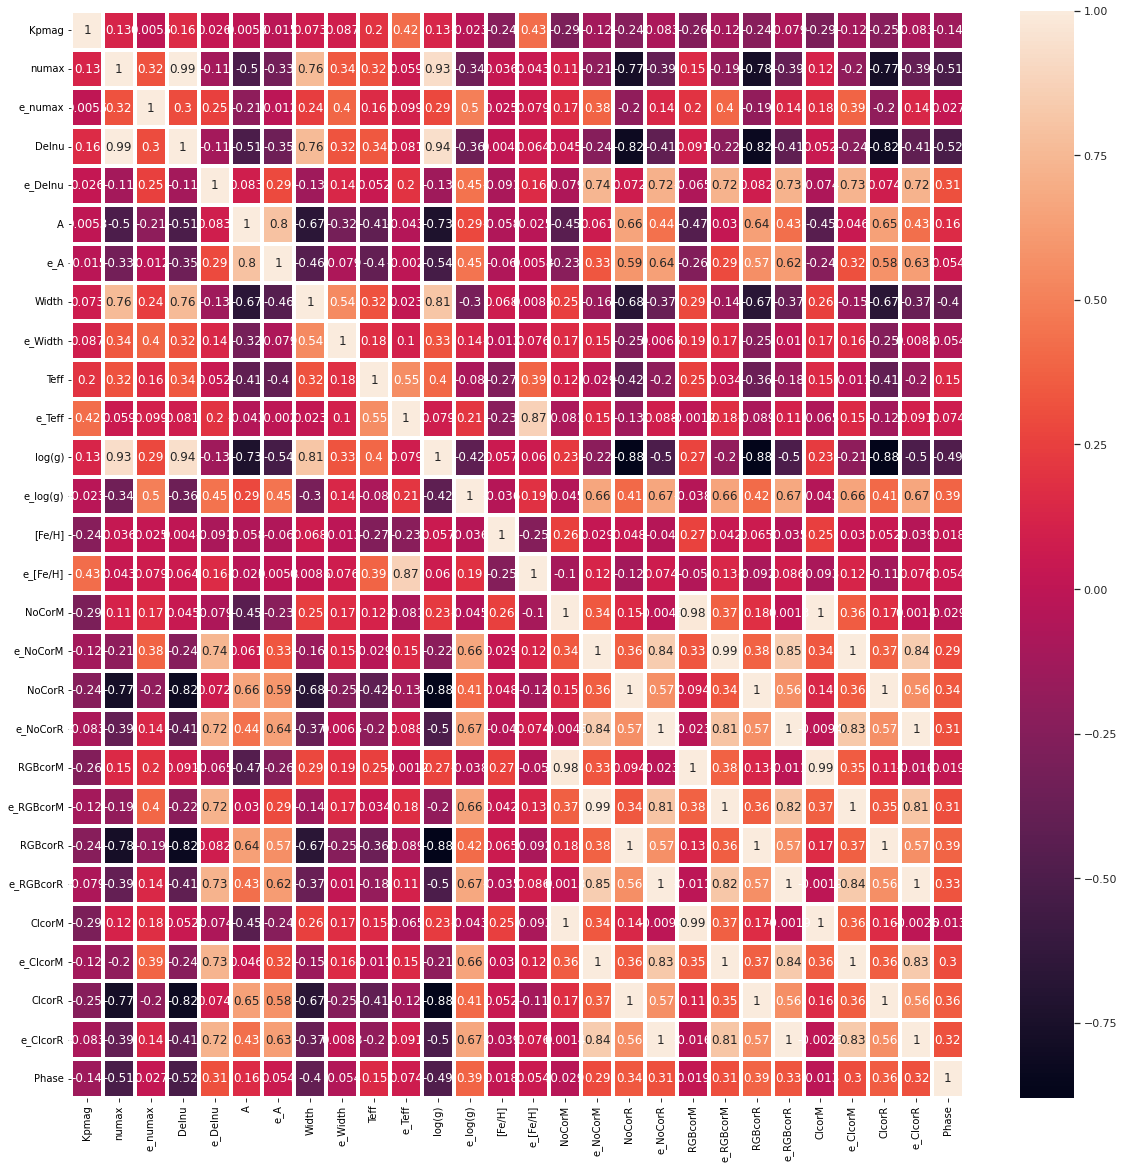

In [9]:
fig, ax = plt.subplots(figsize=(20,20))  
sns.set(font_scale=1.0)
sns.heatmap(df.corr() , annot= True, linewidths=3, ax=ax) 

## Phase is greatly influenced by:




In [10]:
d = {'Phase is greatly influenced by:': ['RGBcorR & e_log(g)', 'ClcorR', 'NoCorR', 'e_RGBcorR', 'e_ClcorR', 'e_RGBcorM & e_NoCorR & e_Delnu',
                            'e_ClcorM', 'e_NoCorM'], 'correlation coefficient': [0.39, 0.36, 0.34, 0.33, 0.32, 0.31, 0.30, 0.29]}
dfC = pd.DataFrame(data=d)
dfC.head(10)

,Phase is greatly influenced by:,correlation coefficient
0,RGBcorR & e_log(g),0.39
1,ClcorR,0.36
2,NoCorR,0.34
3,e_RGBcorR,0.33
4,e_ClcorR,0.32
5,e_RGBcorM & e_NoCorR & e_Delnu,0.31
6,e_ClcorM,0.30
7,e_NoCorM,0.29


**I aim to visualize the first six most influential features and the Phase, so I rewrite the data frame with just these features.**

In [11]:
df_copy = df[['RGBcorR', 'e_log(g)', 'ClcorR', 'NoCorR', 'e_RGBcorR', 'e_ClcorR', 'Phase']] 

# Data Visualization and Analysis:

<Figure size 720x576 with 0 Axes>

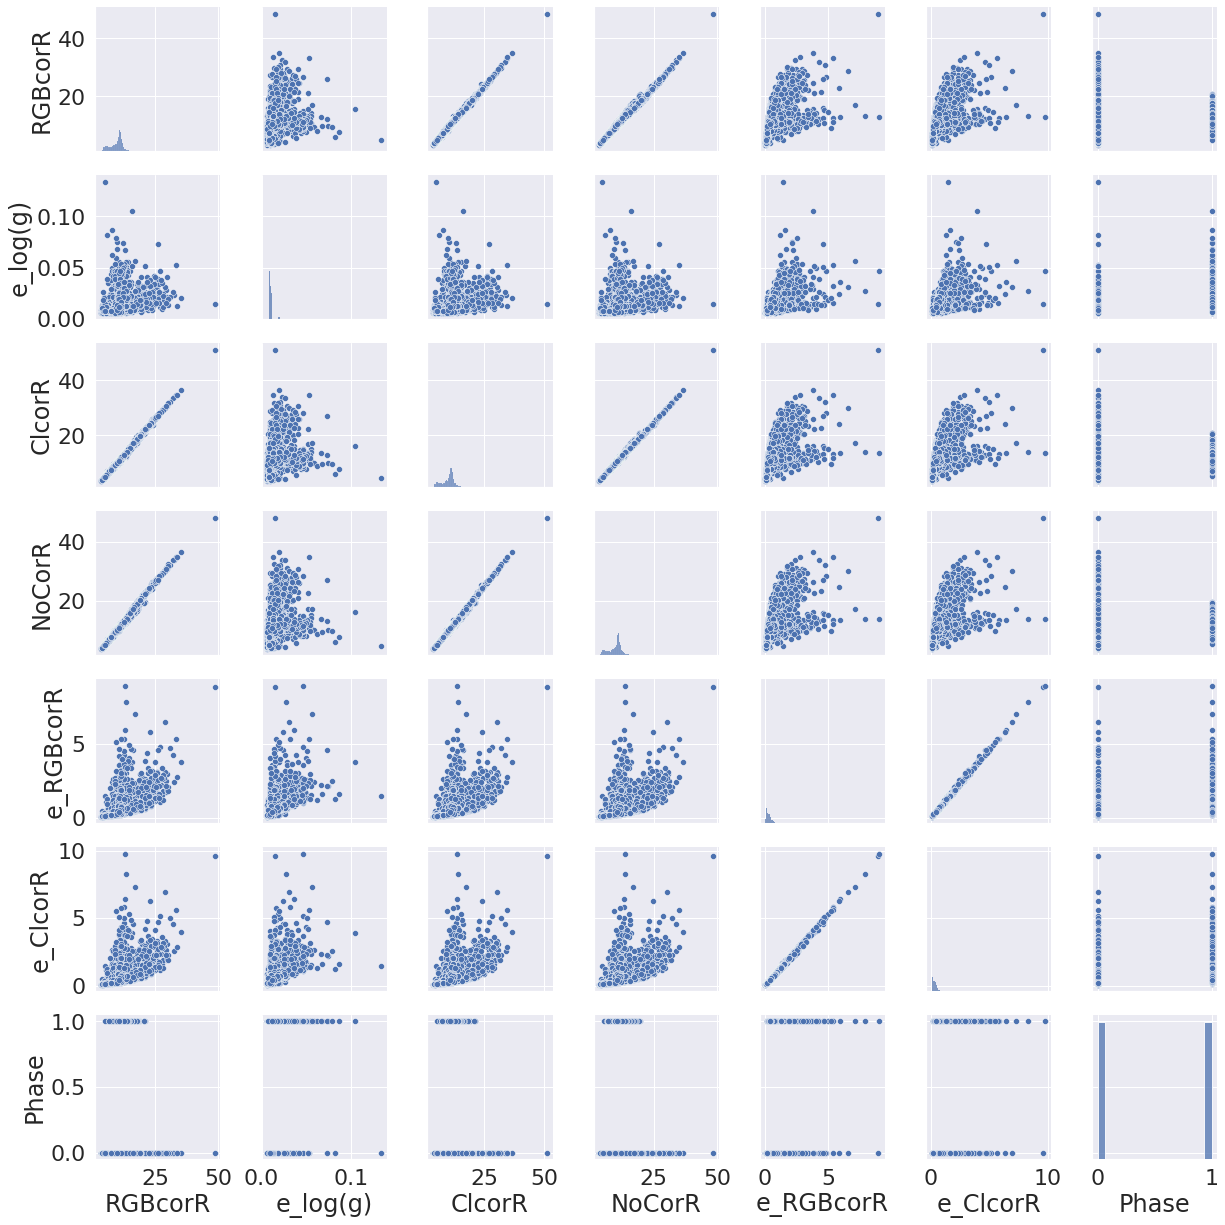

In [12]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=2.0)
sns.pairplot(df_copy)

# Boxplots and outliers

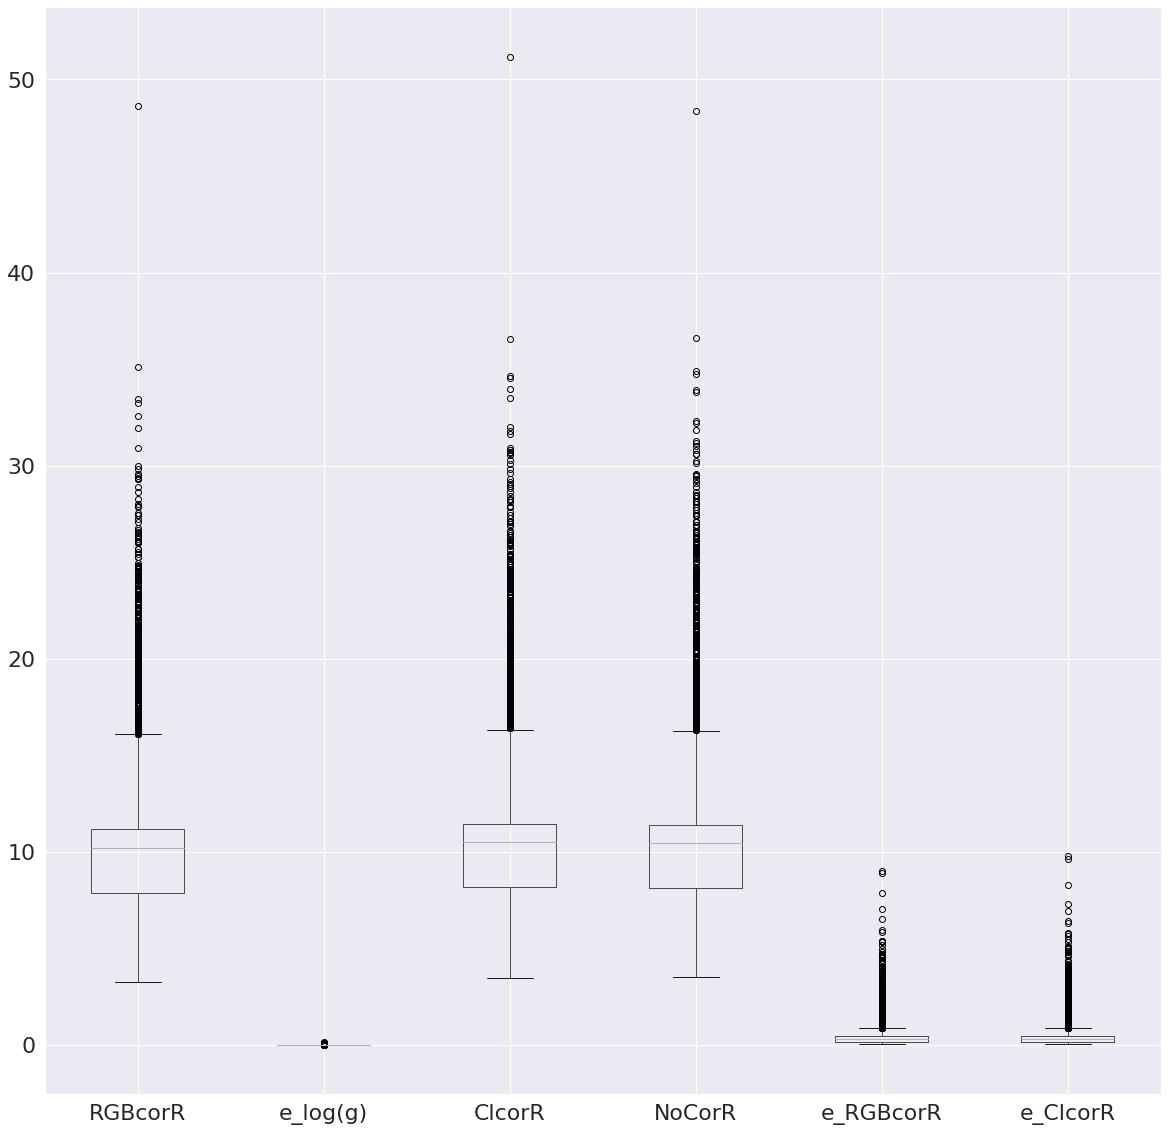

In [13]:
plt.figure(figsize=(20, 20))
boxplot = df_copy.boxplot(column=['RGBcorR', 'e_log(g)', 'ClcorR', 'NoCorR', 'e_RGBcorR', 'e_ClcorR']) 

# The next step is to examine classic machine learning algorithms and TensorFlow.

## I first split the DataFrame into X (data) and Y (labels), where:

In [14]:
X = df.drop(['Phase'], axis=1)
y = df['Phase']  

## Using a train-test split, I split X and Y into train and test data to evaluate the machine learning algorithm's performance.

*   Train Dataset: Used to fit the machine learning model.
*   Test Dataset: Used to evaluate the fit machine learning model.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Normalization
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 1. Classic machine learning algorithms

### SVC

For SVM with an `RBF` (radial basis function) kernel, there are two important parameters: the kernel bandwidth `gamma` and the regularization parameter `C`. The C and gamma values are set to 100 and 1, respectively. 

In [16]:
svm = SVC(C=100, gamma=1)
svm.fit(X_train_scaled, y_train) 

SVC(C=100, gamma=1)

#### Model Accuracy

In [17]:
print('Accuracy of SVC on train set: {:.3f}' .format(svm.score(X_train_scaled, y_train)))
print('Accuracy of SVC on test set: {:.3f}' .format(svm.score(X_test_scaled, y_test)))

Accuracy of SVC on train set: 0.971
Accuracy of SVC on test set: 0.960


**I predicted the correct class on `96%` of the samples in X_test.**

### LogisticRegression

In [18]:
logreg = LogisticRegression(penalty='l2', C=220, solver='liblinear', random_state=42)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=220, random_state=42, solver='liblinear')

#### Model Accuracy

In [19]:
print('Accuracy of LogisticRegression on train set: {:.3f}' .format(logreg.score(X_train_scaled, y_train)))
print('Accuracy of LogisticRegression on test set: {:.3f}' .format(logreg.score(X_test_scaled, y_test)))

Accuracy of LogisticRegression on train set: 0.946
Accuracy of LogisticRegression on test set: 0.944


**I predicted the correct class on `94.4%` of the samples in X_test.**

In [20]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### `ROC` & `Precision_Recall` for LogisticRegression

**For the `ROC Curve`, the ideal curve is close to the top left: I want a classifier that produces a high recall while keeping a low false positive rate. Also, for `Precision_Recall`, the closer a curve stays to the upper right corner, the better the classifier. A point at the upper right means high precision and high recall for the same threshold.**

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


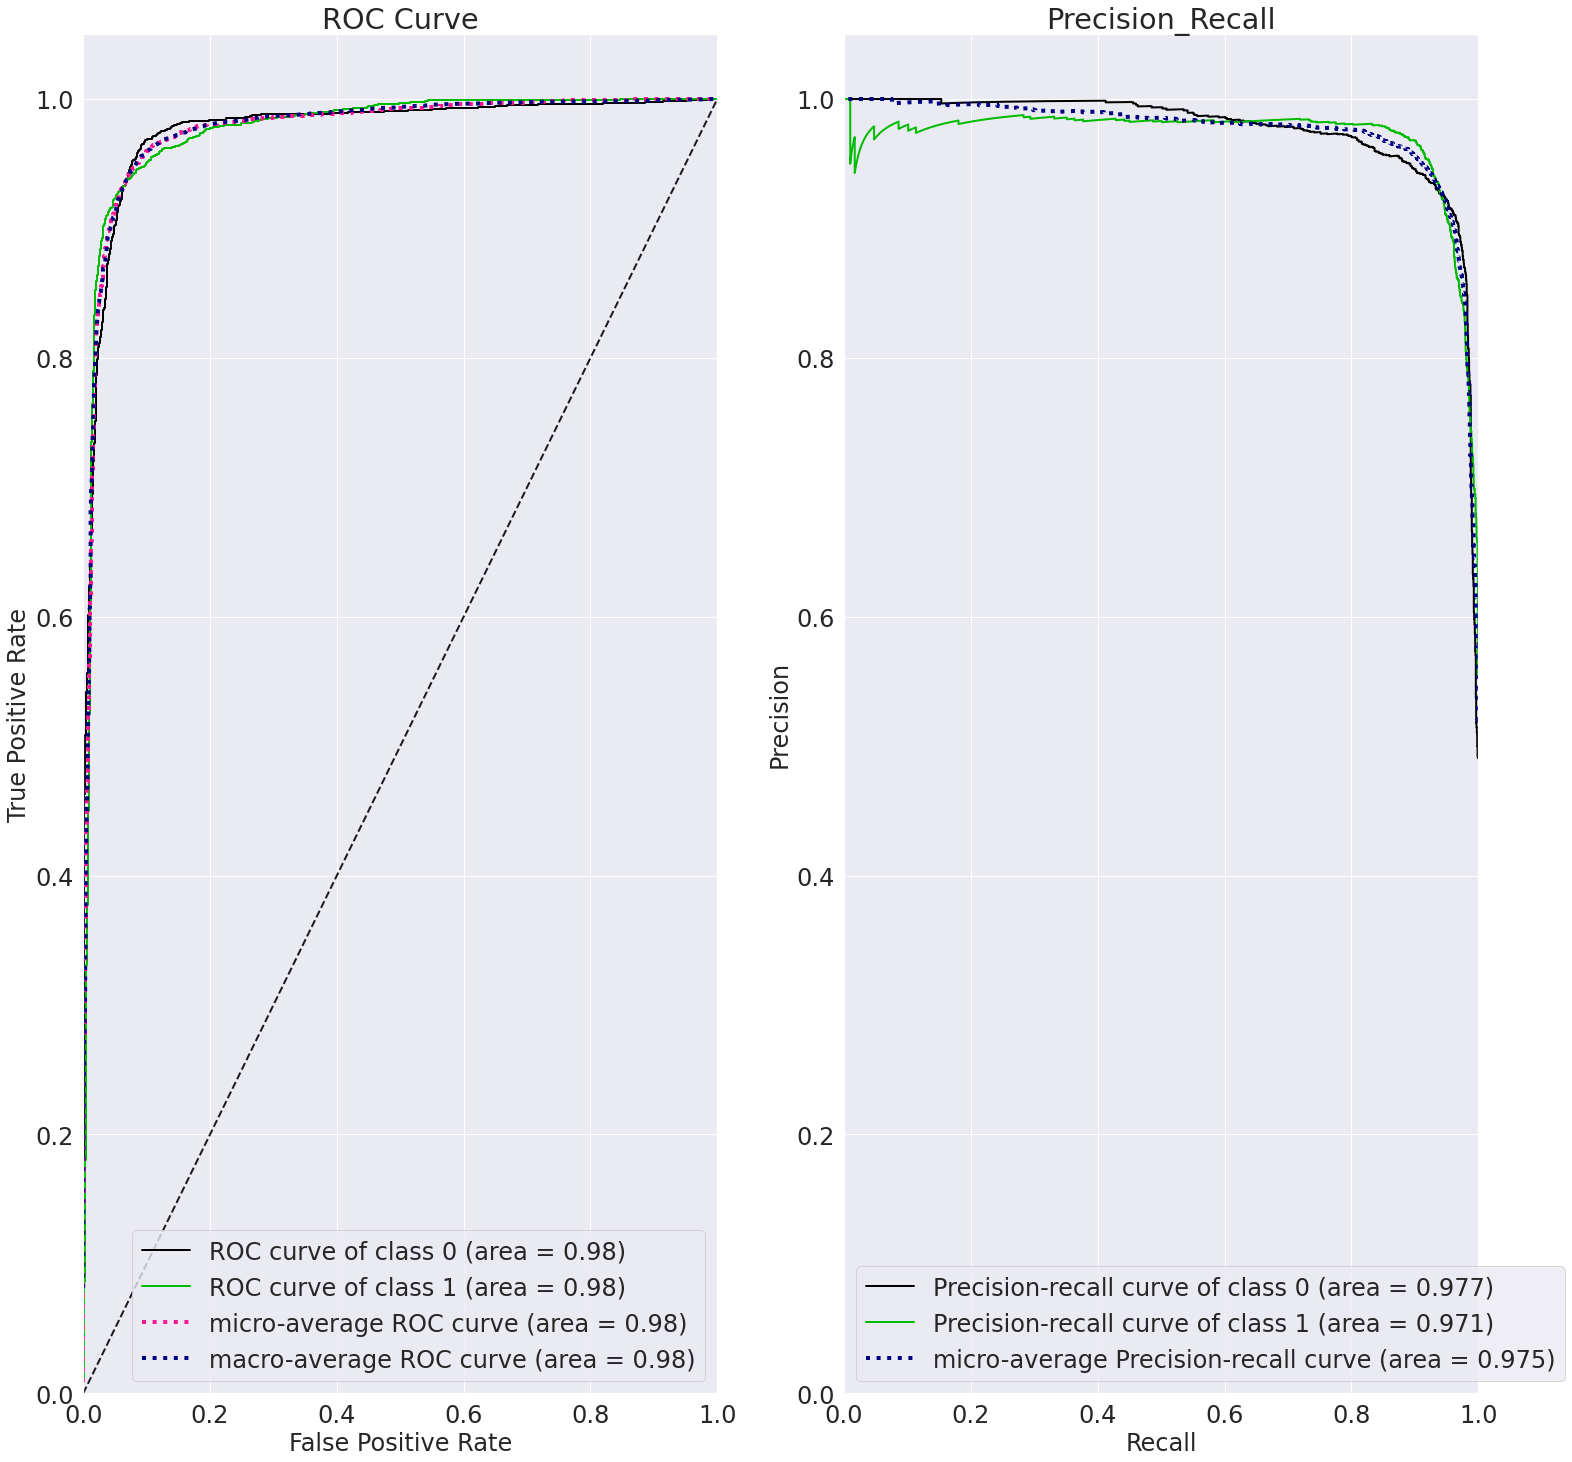

In [21]:
import scikitplot as skplt

logreg.fit(X_train, y_train)

plt.figure(figsize=(25,25))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

skplt.metrics.plot_roc(y_test, logreg.predict_proba(X_test), ax=ax1, title= 'ROC Curve')
skplt.metrics.plot_precision_recall(y_test, logreg.predict_proba(X_test), ax=ax2, title='Precision_Recall')

plt.show()

### KNeighborsClassifier

**Using X_train and y_train, train a KNeighborsClassifier with default parameters and `n_neighbors=13`.**

In [22]:
KNClf = KNeighborsClassifier(n_neighbors = 13)  # KNClf= KNeighborsClassifier
KNClf.fit(X_train_scaled, y_train) 

KNeighborsClassifier(n_neighbors=13)

#### Model prediction

In [23]:
Model_Prediction_knn = KNClf.predict(X_test_scaled)
Model_Prediction_knn

array([0, 0, 1, ..., 1, 1, 1])

#### Model Accuracy

In [24]:
print('Accuracy of KNeighborsClassifier on train set: {:.3f}' .format(KNClf.score(X_train_scaled, y_train)))
print('Accuracy of KNeighborsClassifier on test set: {:.3f}' .format(KNClf.score(X_test_scaled, y_test)))

Accuracy of KNeighborsClassifier on train set: 0.949
Accuracy of KNeighborsClassifier on test set: 0.939


**I predicted the correct class on `93.9%` of the samples in X_test.**

**Is n_neighbors = 13 the best value? Yes, because:**

In [25]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_scaled, y_train)
    yhat = neigh.predict(X_test_scaled)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
    
mean_acc

array([0.92071744, 0.91083962, 0.93345464, 0.93111515, 0.9350143 ,
       0.9350143 , 0.93605407, 0.93553418, 0.93657395, 0.93657395,
       0.93605407, 0.93761372, 0.93891344, 0.93839355])

**To better understand, I visualize previous cell to see better the relationship between Accuracy and Number of Neighbors(K).**

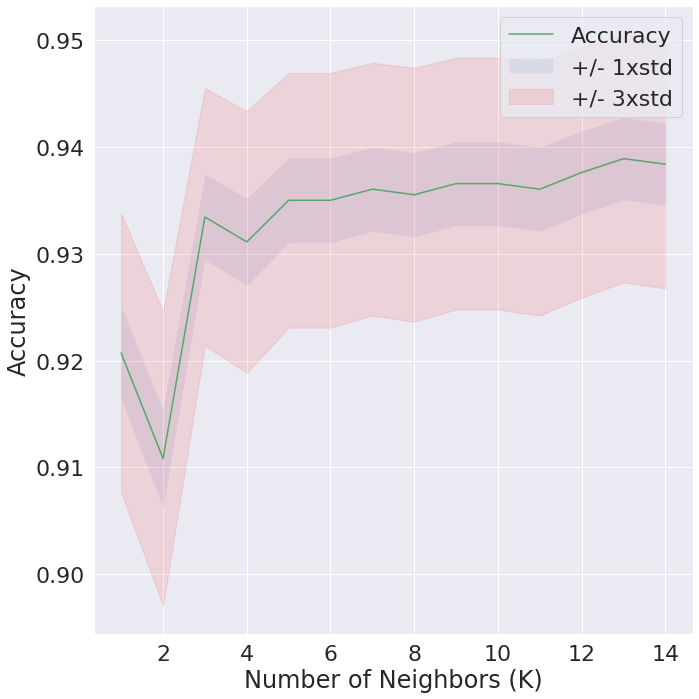

In [26]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 16})
plt.plot(range(1,Ks), mean_acc, 'g')
plt.fill_between(range(1,Ks), mean_acc - 1 * std_acc, mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks), mean_acc - 3 * std_acc, mean_acc + 3 * std_acc, alpha=0.10, color='red')
plt.legend(('Accuracy', '+/- 1xstd', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [27]:
print("The best accuracy is {:.3f}" .format(mean_acc.max()), "with k =", mean_acc.argmax()+ 1)

The best accuracy is 0.939 with k = 13


In [28]:
print(classification_report(y_test, Model_Prediction_knn))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      1879
           1       0.94      0.95      0.94      1968

    accuracy                           0.94      3847
   macro avg       0.94      0.94      0.94      3847
weighted avg       0.94      0.94      0.94      3847



### DecisionTreeClassifier

**Using X_train and y_train, train a DecisionTreeClassifier with `default parameters` and `random_state=0`.**

In [29]:
DTClf = DecisionTreeClassifier(random_state = 0)  #DTClf = Decision Tree Classifier
DTClf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [30]:
Model_Prediction = DTClf.predict(X_test)

**In order to show easily the differences between `model-based prediction` and `real values`, I create a dataframe.**

In [31]:
d = {'real or true values(y_test)': y_test, 'Model_Prediction': Model_Prediction}
dfC = pd.DataFrame(data=d)
dfC.head(10)

,real or true values(y_test),Model_Prediction
3708,1,1
3402,0,0
10825,1,1
11527,1,1
11243,0,0
15170,0,0
8366,1,1
14391,0,0
3795,0,0
13119,0,0


#### Model Accuracy

In [32]:
print('Accuracy of Decision Tree classifier on train set: {:.3f}' .format(DTClf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}' .format(DTClf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on train set: 1.000
Accuracy of Decision Tree classifier on test set: 0.937


**I predicted the correct class on `93.7%` of the samples in X_test.**

### RandomForestClassifier

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [33]:
RFClf = RandomForestClassifier(n_estimators=300, criterion='entropy', min_samples_leaf=2, random_state=0) # RFClf = RandomForestClassifier
RFClf.fit(X_train, y_train) 

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       n_estimators=300, random_state=0)

#### Model Accuracy

In [34]:
print('Accuracy of RandomForestClassifier on train set: {:.3f}' .format(RFClf.score(X_train, y_train)))
print('Accuracy of RandomForestClassifier on test set: {:.3f}' .format(RFClf.score(X_test, y_test)))

Accuracy of RandomForestClassifier on train set: 0.996
Accuracy of RandomForestClassifier on test set: 0.957


**I predicted the correct class on `95.7%` of the samples in X_test.**

### AdaBoostClassifier

In [35]:
ABClf = AdaBoostClassifier(n_estimators=400, random_state=0) # ABClf = AdaBoostClassifier
ABClf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=400, random_state=0)

#### Model Accuracy

In [36]:
print('Accuracy of AdaBoostClassifier on train set: {:.3f}' .format(ABClf.score(X_train, y_train)))
print('Accuracy of AdaBoostClassifier on test set: {:.3f}' .format(ABClf.score(X_test, y_test)))

Accuracy of AdaBoostClassifier on train set: 0.971
Accuracy of AdaBoostClassifier on test set: 0.955


**I predicted the correct class on `95.5%` of the samples in X_test.**

### VotingClassifier

**Combining three algorithms, Random Forest Classifier, AdaBoost Classifier, and SVM, I achieve high accuracy. For this, I use `VotingClassifier`.**

In [37]:
eclf1 = VotingClassifier(estimators=[
        ('svm', svm), ('rf', RFClf), ('ab', ABClf)], voting='hard') 
eclf1.fit(X_train_scaled, y_train) 

VotingClassifier(estimators=[('svm', SVC(C=100, gamma=1)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     min_samples_leaf=2,
                                                     n_estimators=300,
                                                     random_state=0)),
                             ('ab',
                              AdaBoostClassifier(n_estimators=400,
                                                 random_state=0))])

#### Model Accuracy

In [38]:
print('Accuracy of VotingClassifier on train set: {:.3f}' .format(eclf1.score(X_train_scaled, y_train)))
print('Accuracy of VotingClassifier on test set: {:.3f}' .format(eclf1.score(X_test_scaled, y_test)))

Accuracy of VotingClassifier on train set: 0.982
Accuracy of VotingClassifier on test set: 0.962


**On `96.2%` of the samples in X_test, I correctly predicted the class.**

### Neural_Network.MLPClassifier

In [39]:
NNClf = MLPClassifier(hidden_layer_sizes=(300,), activation='relu', random_state=0, max_iter=300)
NNClf.fit(X_train_scaled, y_train)

MLPClassifier(hidden_layer_sizes=(300,), max_iter=300, random_state=0)

#### Model Accuracy

In [40]:
print('Accuracy of MLPClassifier on train set: {:.3f}' .format(NNClf.score(X_train_scaled, y_train)))
print('Accuracy of MLPClassifier on test set: {:.3f}' .format(NNClf.score(X_test_scaled, y_test)))

Accuracy of MLPClassifier on train set: 0.970
Accuracy of MLPClassifier on test set: 0.965


**I predicted the correct class on `96.5%` of the samples in X_test.**

### As a data frame, model accuracies are as follows:

In [41]:
d = {'Model': ['Neural_Network.MLPClassifier', 'VotingClassifier', 'SVC', 'RandomForestClassifier', 'AdaBoostClassifier', 
               'LogisticRegression', 'KNeighborsClassifier', 'DecisionTreeClassifier'], 'Accuracy': [96.5, 96.2, 96, 95.7, 95.5, 94.4, 93.9, 93.7]}
dfC = pd.DataFrame(data=d)
dfC

,Model,Accuracy
0,Neural_Network.MLPClassifier,96.5
1,VotingClassifier,96.2
2,SVC,96.0
3,RandomForestClassifier,95.7
4,AdaBoostClassifier,95.5
5,LogisticRegression,94.4
6,KNeighborsClassifier,93.9
7,DecisionTreeClassifier,93.7


**Here I plot `ROC Curves` that reflect ROC scores in comparison charts. This provides us with a better understanding of which algorithm works best for our dataset.**

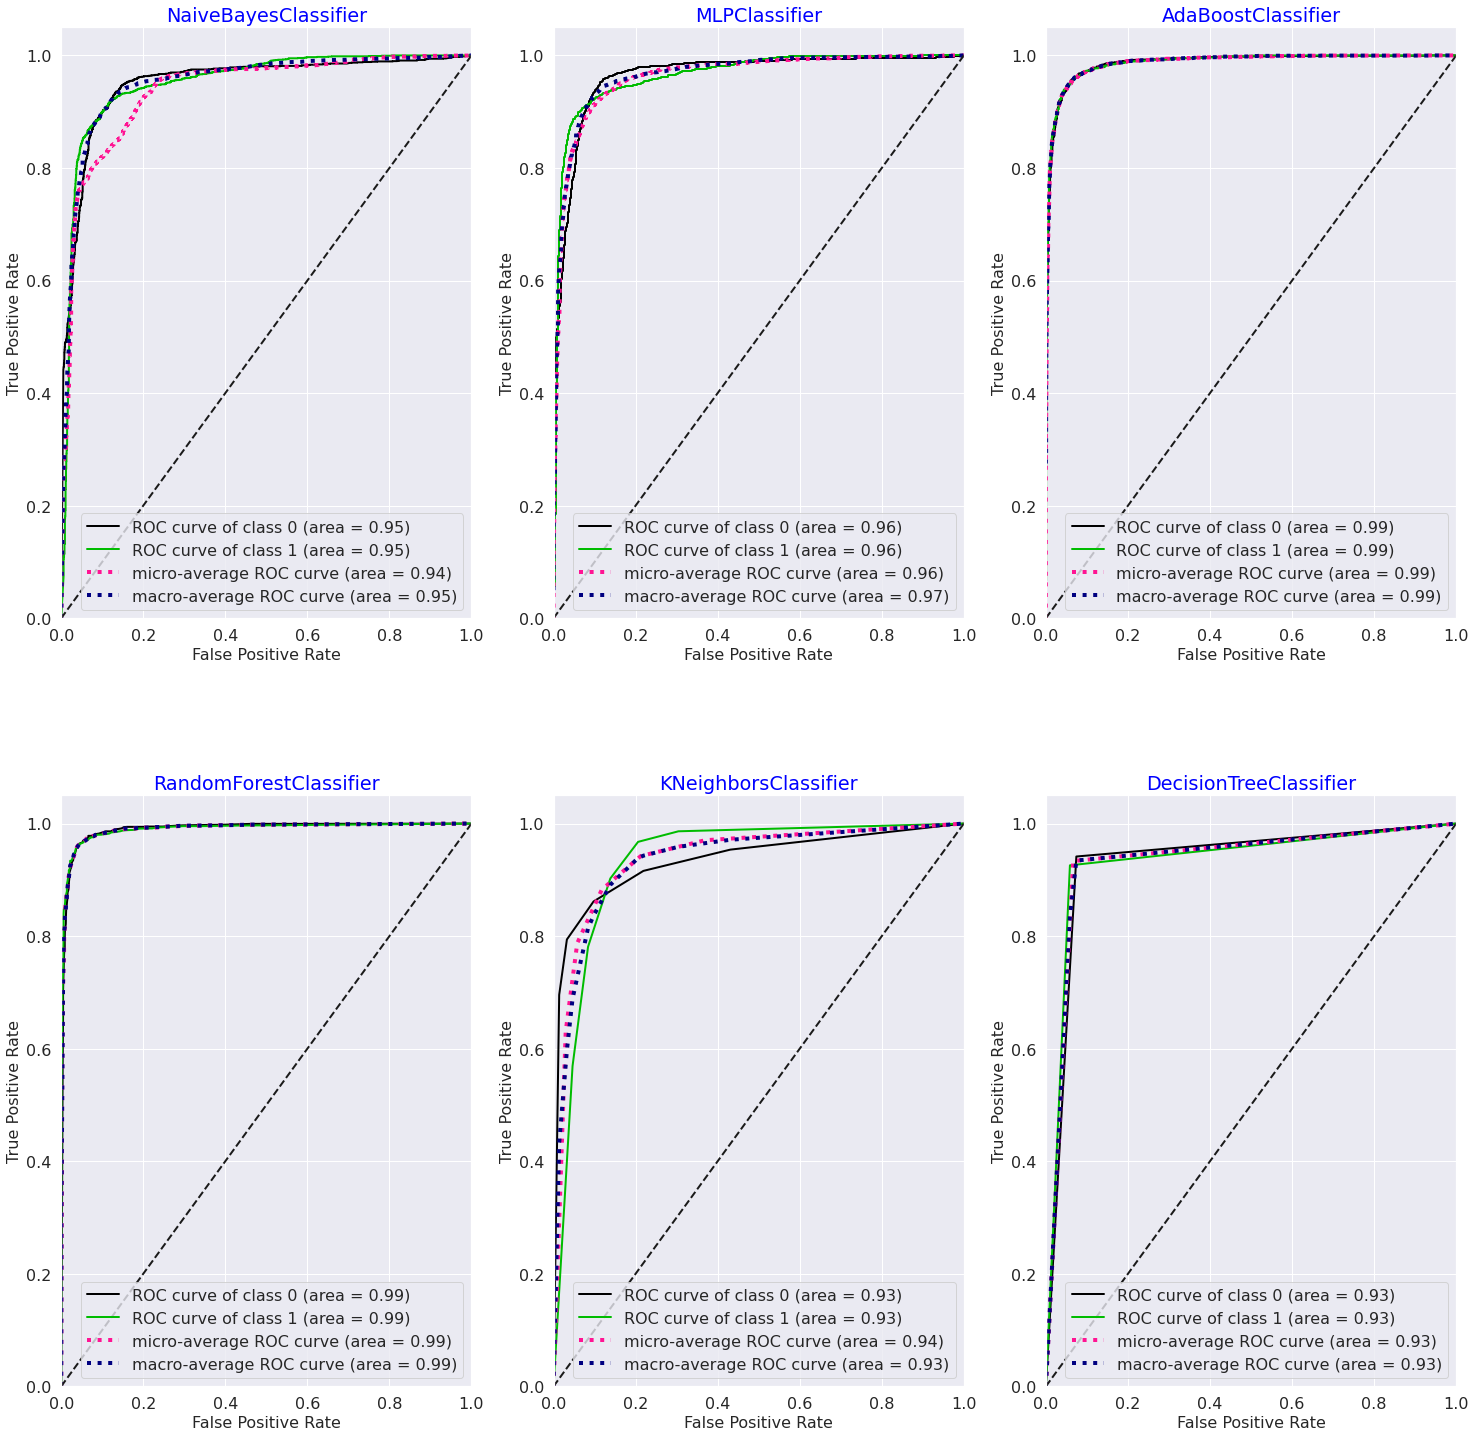

In [42]:
NBC = GaussianNB() 
NNC = MLPClassifier(random_state=1, max_iter=300)
ABC = AdaBoostClassifier()
RFC = RandomForestClassifier()
KNC = KNeighborsClassifier()
DTC = DecisionTreeClassifier()

classifiers = [NBC, NNC, ABC, RFC, KNC, DTC] 
title = ['NaiveBayesClassifier','MLPClassifier','AdaBoostClassifier','RandomForestClassifier',
         'KNeighborsClassifier', 'DecisionTreeClassifier']

for cls in classifiers:
    cls.fit(X_train, y_train)

plt.figure(figsize=(25,25))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.3)

for i in range(6):

    col, row = i%3,i//3
    ax = plt.subplot(grid[row,col]) 
    ax.title.set_color('blue')

    model = classifiers[i]
    skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), ax=ax, title=title[i])

plt.show()

**Additionally, I plot the `Precision-Recall Curve` and `Confusion Matrix` to determine which algorithms are best for this dataset in general.**

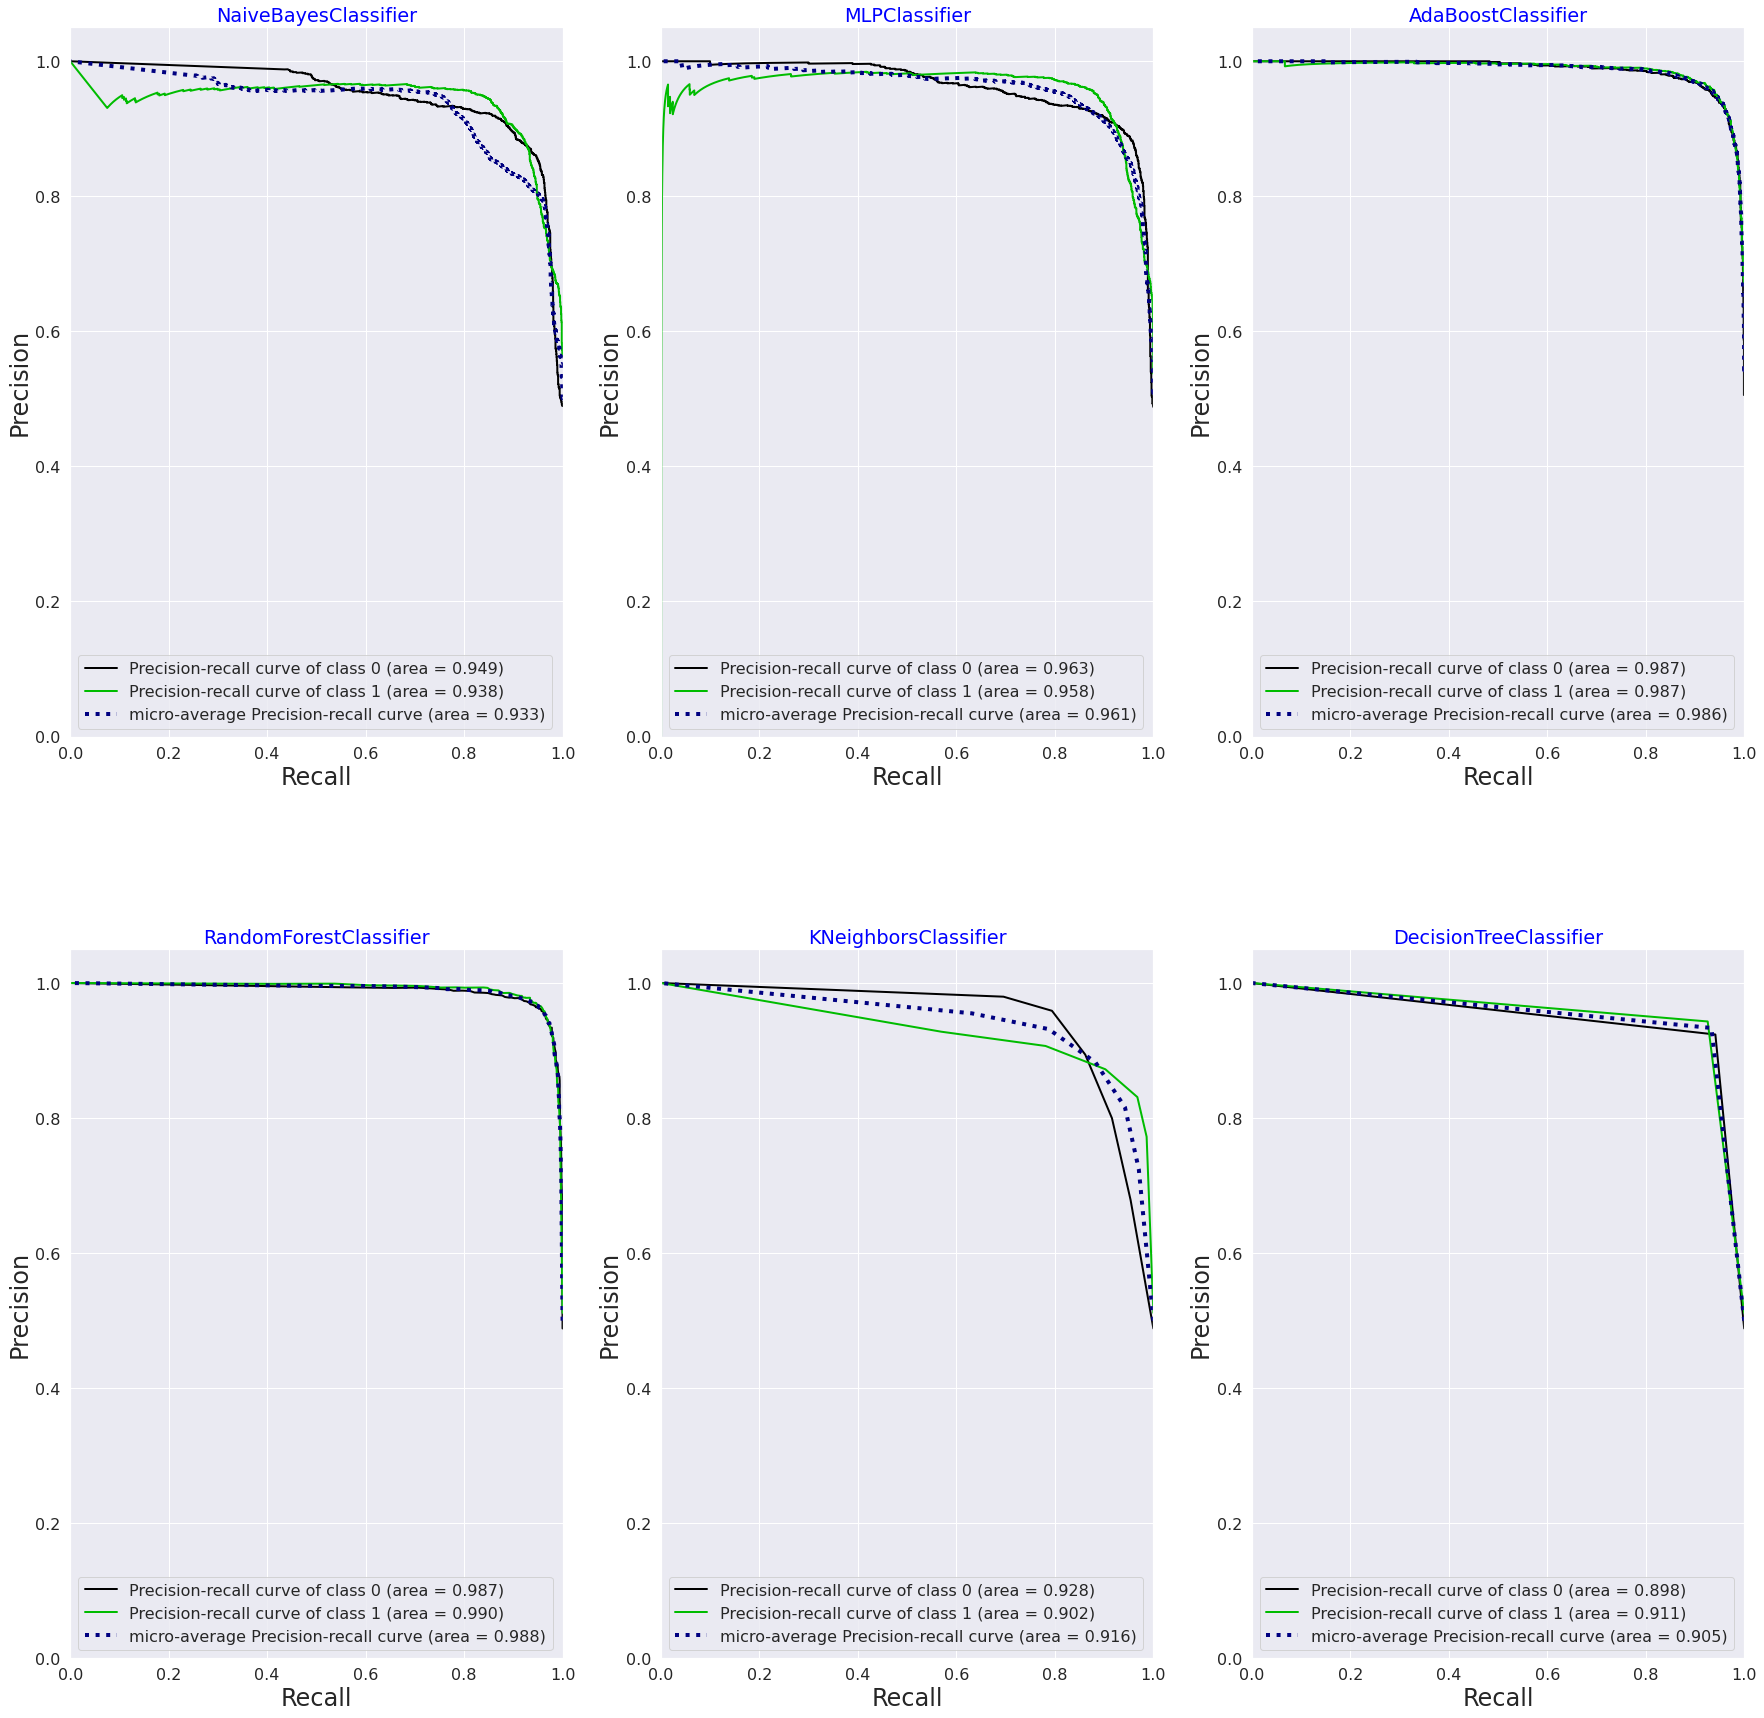

In [43]:
plt.figure(figsize=(30,30))
grid = plt.GridSpec(2, 3, wspace=0.2, hspace=0.3)

for i in range(6):

    col, row = i%3,i//3
    ax = plt.subplot(grid[row,col]) 
    ax.title.set_color('blue')

    model = classifiers[i]
    skplt.metrics.plot_precision_recall(y_test, model.predict_proba(X_test), ax=ax, title=title[i])

plt.show()

**On the basis of ROC Curves, the best algorithms for classes are respectively:**


In [44]:
d = {'class 0': ['AdaBoostClassifier & RandomForestClassifier', 'LogisticRegression', 'MLPClassifier', 'NaiveBayesClassifier', 'KNeighborsClassifier & DecisionTreeClassifier'], 
     'class 1': ['AdaBoostClassifier & RandomForestClassifier', 'LogisticRegression', 'MLPClassifier', 'NaiveBayesClassifier', 'KNeighborsClassifier & DecisionTreeClassifier']} 
dfC = pd.DataFrame(data=d)
dfC.head(10)

,class 0,class 1
0,AdaBoostClassifier & RandomForestClassifier,AdaBoostClassifier & RandomForestClassifier
1,LogisticRegression,LogisticRegression
2,MLPClassifier,MLPClassifier
3,NaiveBayesClassifier,NaiveBayesClassifier
4,KNeighborsClassifier & DecisionTreeClassifier,KNeighborsClassifier & DecisionTreeClassifier


**On the basis of Precision-Recall Curves, the best algorithms for classes are respectively:**

In [45]:
d = {'class 0': ['AdaBoostClassifier & RandomForestClassifier', 'LogisticRegression', 'MLPClassifier', 'NaiveBayesClassifier', 'KNeighborsClassifier', 'DecisionTreeClassifier', ''], 
     'class 1': ['RandomForestClassifier', 'AdaBoostClassifier', 'LogisticRegression', 'MLPClassifier', 'NaiveBayesClassifier', 'DecisionTreeClassifier', 'KNeighborsClassifier']} 
dfC = pd.DataFrame(data=d)
dfC.head(10) 

,class 0,class 1
0,AdaBoostClassifier & RandomForestClassifier,RandomForestClassifier
1,LogisticRegression,AdaBoostClassifier
2,MLPClassifier,LogisticRegression
3,NaiveBayesClassifier,MLPClassifier
4,KNeighborsClassifier,NaiveBayesClassifier
5,DecisionTreeClassifier,DecisionTreeClassifier
6,,KNeighborsClassifier


**Confusion Matrix**

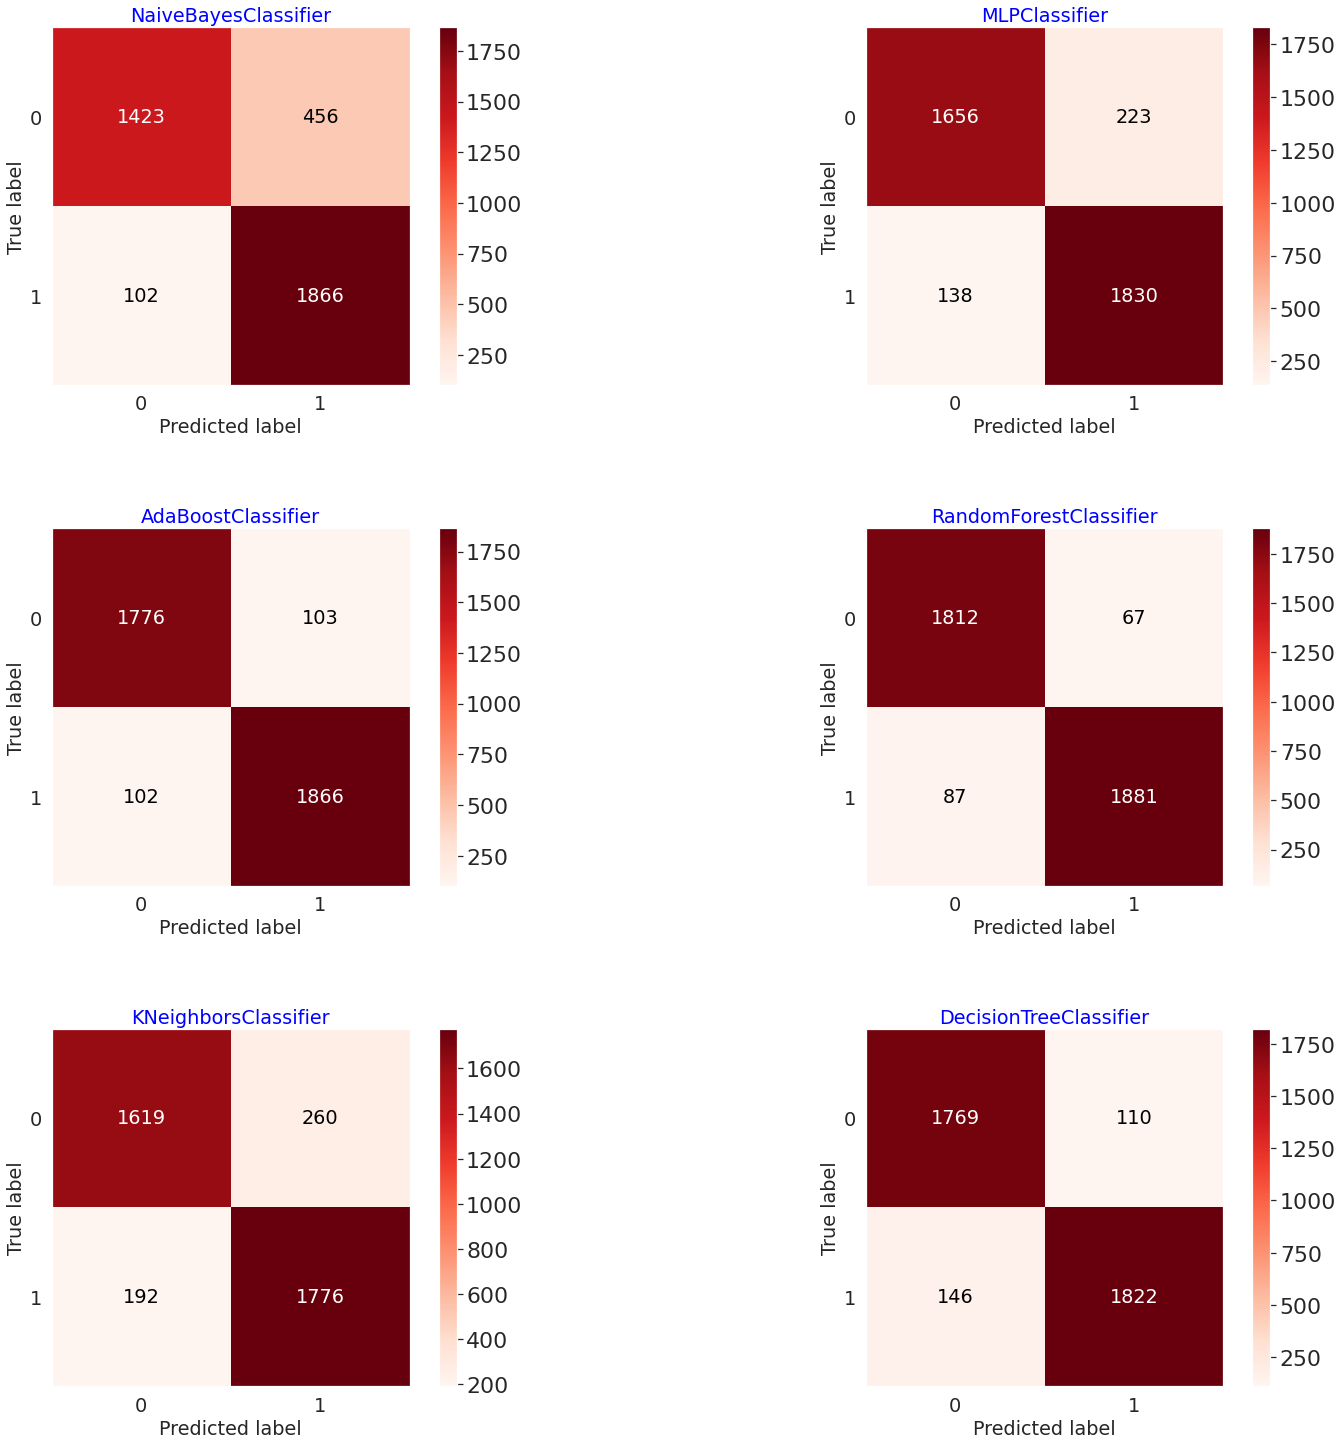

In [46]:
plt.figure(figsize=(25, 25))
grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.4)


for i in range(6):

    col, row = i%2,i//2
    ax = plt.subplot(grid[row,col]) 
    ax.title.set_color('blue')

    model = classifiers[i]
    skplt.metrics.plot_confusion_matrix(y_test, model.predict(X_test), ax=ax, cmap='Reds', title=title[i], text_fontsize='large')

plt.show()

**Just RandomForestClassifier is interpreted, others are the same.**


*   The model predicts 1882 records as HeB phase.
*   1806 records are predicted to be RGB phase.


*   In this case, the model incorrectly predicts 73 records as HeB phase.
*   The model incorrectly predicts 86 records as being RGB phase when in fact, they are HeB phase.


1 = HeB (Helium Burning) phase;

0 = RGB (Red-Giant-Branch) phase;



## 2. TensorFlow

The first thing I do is train a simple Neural Network using TensorFlow, and then plot accuracy and loss graphs on the training and validation datasets to find a balance between the model that is underfitting and one that is overfitting, resulting in a model with a good fit. I first need to convert the train and test data into a TensorFlow tensor. 

### To convert DataFrame to a tensor, I use `tf.convert_to_tensor`

In [47]:
tf.convert_to_tensor(X_train)

<tf.Tensor: shape=(11541, 27), dtype=float64, numpy=
array([[1.4180e+01, 3.0250e+01, 6.9000e-01, ..., 1.1000e-01, 1.1320e+01,
        3.9000e-01],
       [8.8800e+00, 6.4630e+01, 1.1200e+00, ..., 1.9000e-01, 1.0700e+01,
        3.2000e-01],
       [1.2440e+01, 3.9250e+01, 7.3000e-01, ..., 1.1000e-01, 1.1380e+01,
        3.1000e-01],
       ...,
       [1.2943e+01, 2.1363e+02, 2.0600e+00, ..., 7.0000e-02, 4.3100e+00,
        9.0000e-02],
       [1.0720e+01, 1.5956e+02, 1.1200e+00, ..., 8.0000e-02, 5.9800e+00,
        1.1000e-01],
       [1.1920e+01, 3.8430e+01, 1.0300e+00, ..., 1.5000e-01, 1.1650e+01,
        3.9000e-01]])>

In [48]:
tf.convert_to_tensor(X_test)

<tf.Tensor: shape=(3847, 27), dtype=float64, numpy=
array([[13.84, 44.77,  0.8 , ...,  0.17, 11.62,  0.47],
       [12.61, 36.52,  0.31, ...,  0.08, 11.33,  0.24],
       [ 9.9 , 68.63,  0.59, ...,  0.13, 10.37,  0.24],
       ...,
       [ 8.85, 39.69,  1.21, ...,  0.16, 10.83,  0.46],
       [12.43, 39.75,  0.78, ...,  0.16, 11.22,  0.52],
       [11.74, 44.46,  0.68, ...,  0.13, 11.24,  0.32]])>

### Normalize X_train

In [49]:
X_train_scaled = tf.keras.layers.Normalization(axis=-1)
X_train_scaled.adapt(X_train)

### Building a simple neural network model

The compile function takes three arguments: optimizer, loss, and metrics.


*   **Optimizer**: These are certain algorithms that are used to change the attributes of the neural network to decrease the loss rate.
*   **Loss**: This is used to compute the quantity that a model should seek to minimize during training.


*   **Metrics**: This is used to judge the performance of the model.





In [50]:
def get_basic_model():
  model = tf.keras.Sequential([
    X_train_scaled,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model
model = get_basic_model()
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_test, y_test)) 

Epoch 1/1000
361/361 [==============================] - 2s 4ms/step - loss: 0.3258 - accuracy: 0.8744 - val_loss: 0.2101 - val_accuracy: 0.9345
Epoch 2/1000
361/361 [==============================] - 1s 3ms/step - loss: 0.1751 - accuracy: 0.9403 - val_loss: 0.1676 - val_accuracy: 0.9418
Epoch 3/1000
361/361 [==============================] - 1s 2ms/step - loss: 0.1509 - accuracy: 0.9477 - val_loss: 0.1526 - val_accuracy: 0.9472
Epoch 4/1000
361/361 [==============================] - 1s 2ms/step - loss: 0.1402 - accuracy: 0.9532 - val_loss: 0.1420 - val_accuracy: 0.9511
Epoch 5/1000
361/361 [==============================] - 1s 2ms/step - loss: 0.1329 - accuracy: 0.9548 - val_loss: 0.1362 - val_accuracy: 0.9537
Epoch 6/1000
361/361 [==============================] - 1s 2ms/step - loss: 0.1277 - accuracy: 0.9568 - val_loss: 0.1367 - val_accuracy: 0.9537
Epoch 7/1000
361/361 [==============================] - 1s 2ms/step - loss: 0.1236 - accuracy: 0.9580 - val_loss: 0.1377 - val_accuracy:

### Evaluate the model

I create plots from the collected history data.

*   A plot of accuracy on the training and validation datasets over training epochs.
*   A plot of loss on the training and validation datasets over training epochs.




121/121 - 0s - loss: 0.1363 - accuracy: 0.9607 - 140ms/epoch - 1ms/step


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


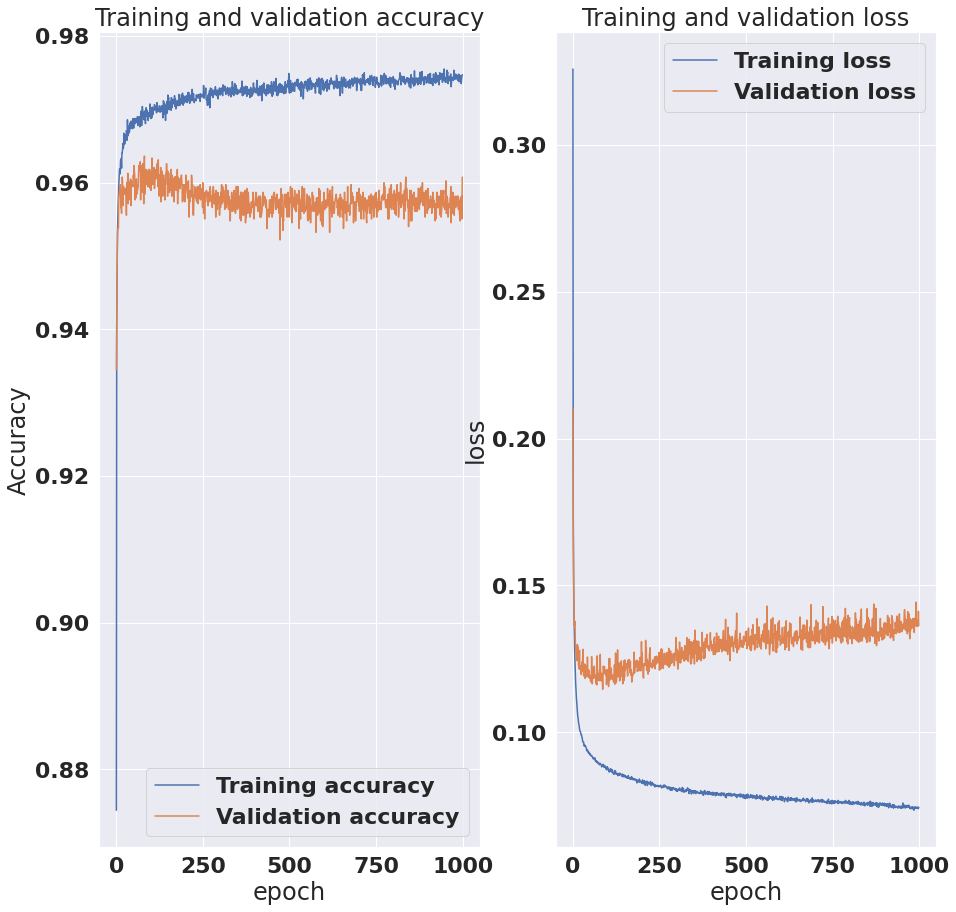

In [51]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(15,15))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy') 
ax1.set_title("Training and validation accuracy")
ax1.set(xlabel='epoch', ylabel='Accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title("Training and validation loss")
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(loc='upper right')
#To check the network accuracy on test data
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

According to the plot of loss, validation loss is decreasing before the 50-55th epoch, so the model
is underfitting. However, after the 50-55th epoch, validation loss is increasing, meaning the model
is overfitting. Around the 50-55th epoch, when the model is either perfectly fitted or in a local
minimum, the neural network model achieved an accuracy of 96%.
The goal of Deep Learning training is to find a balance between a model that is underfitting
and one that is overfitting, resulting in a model with a good fit. I found an optimum where the
change in the slope of loss is around the 50-55th epoch, as shown above. At that point, the training
process can be stopped.


## In comparison to the last one, do complicated neural networks produce better results?

**Here are four neural network models that I checked but didn't include their codes.**

## I just added a layer with 16 neurons to the last simple model in the following model.

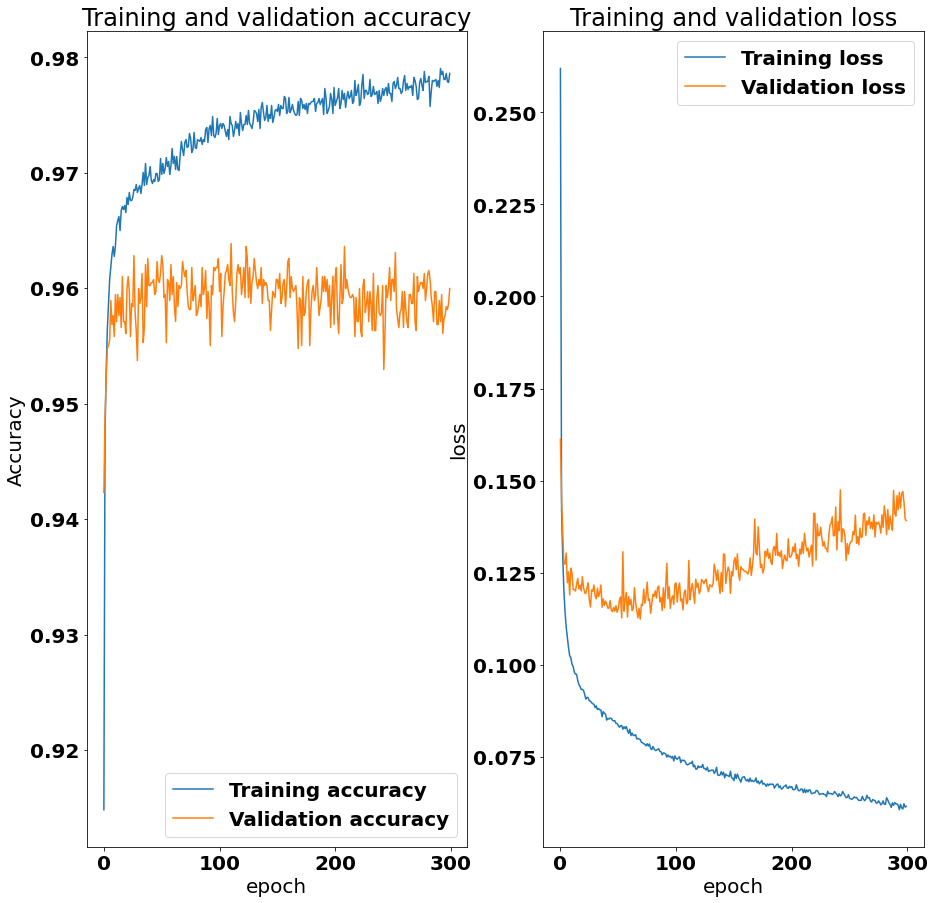

In [52]:
image = cv2.imread('2.png',  cv2.IMREAD_UNCHANGED)
cv2_imshow(image) 

## A 16-neuron layer was also added to the last one.

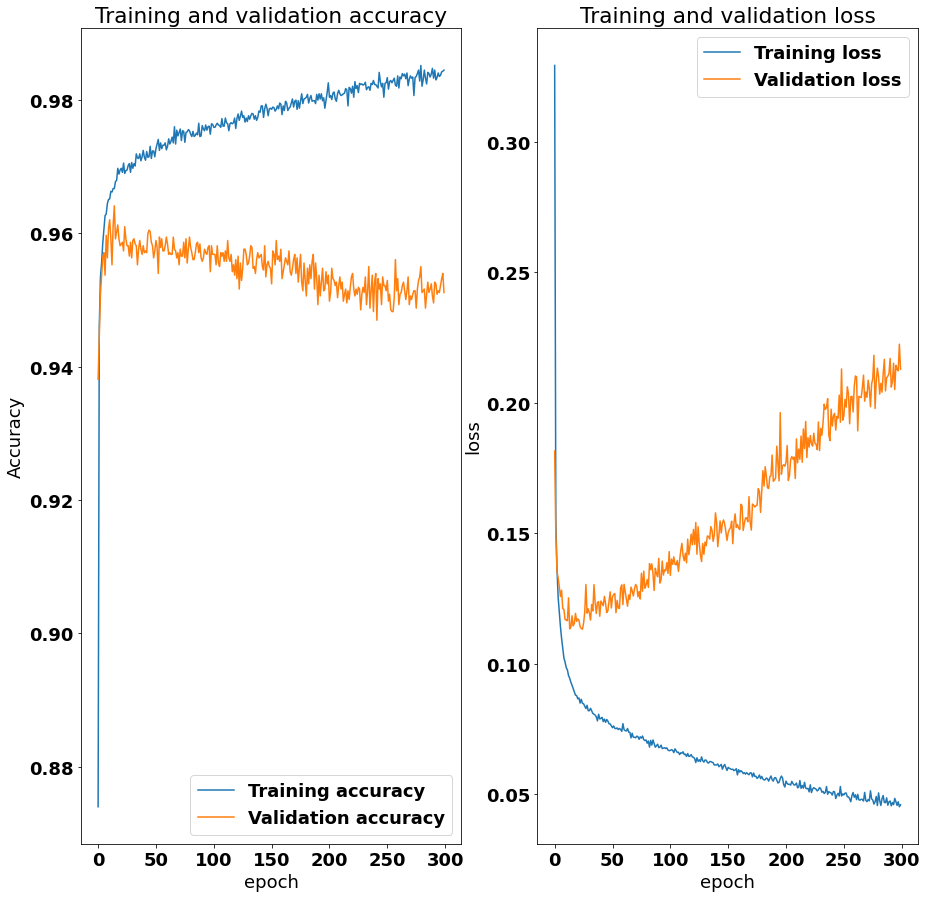

In [53]:
image = cv2.imread('3.png',  cv2.IMREAD_UNCHANGED)
cv2_imshow(image) 

## There are four Dense layers here, each containing 16 neurons.

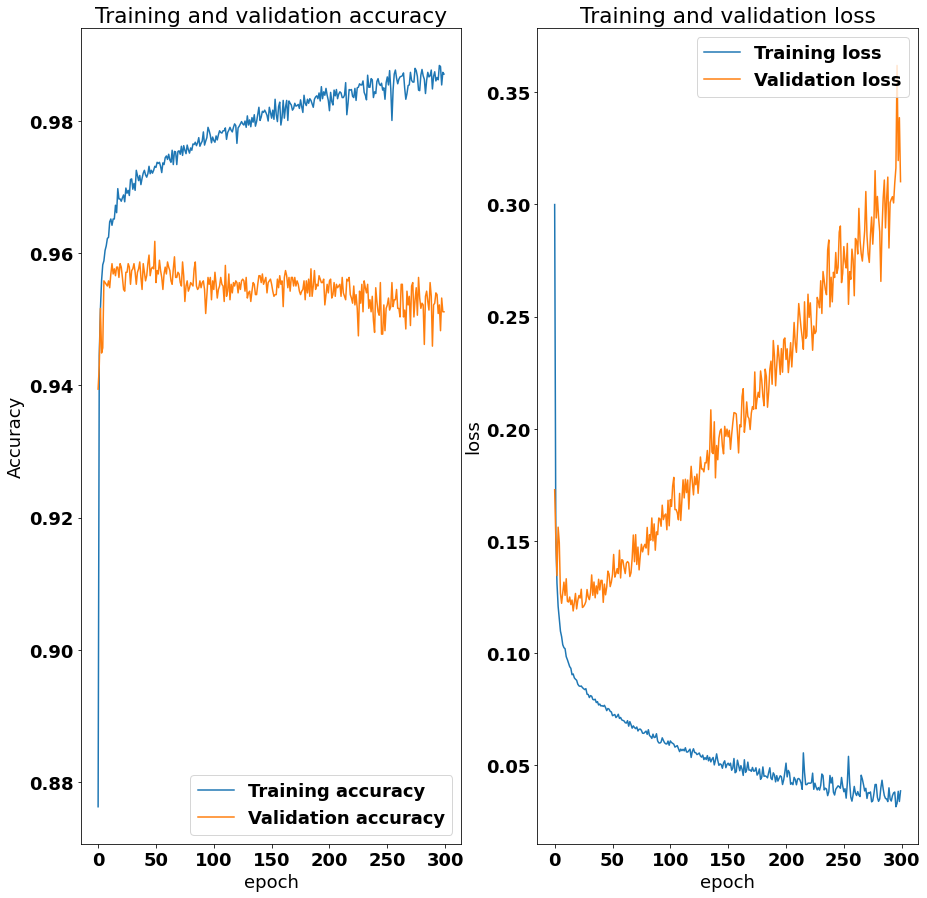

In [54]:
image = cv2.imread('4.png',  cv2.IMREAD_UNCHANGED)
cv2_imshow(image) 

## Since the last three models did not show significant results, I increased the number of neurons in the first model from 16 to 32.

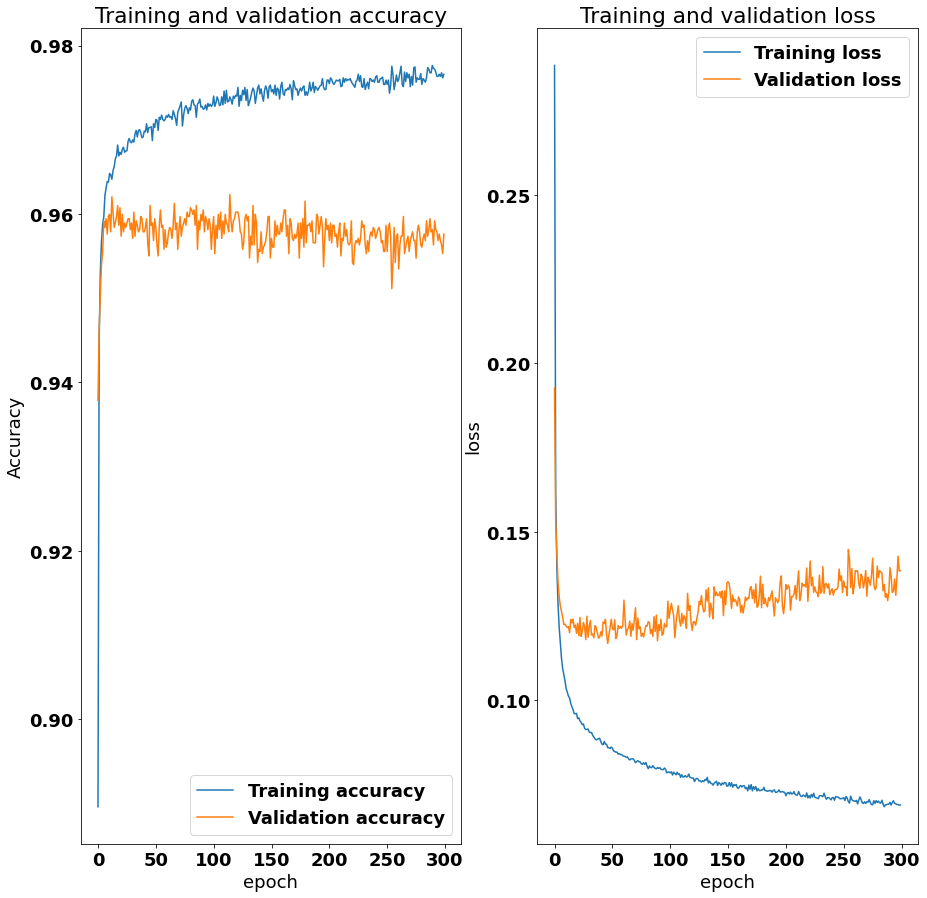

In [55]:
image = cv2.imread('32.png',  cv2.IMREAD_UNCHANGED)
cv2_imshow(image) 

# Final words

I used five neural network models to find out which one has the best performance and accuracy and understood there is no big difference between them in terms of accuracy, but they have their own characteristics in terms of loss graphs. In the first four models in loss graphs, the slope of validation loss increased as layers were added. There is one thing in common between them: Severe fluctuations after the local minimum in loss graphs. This is a sign of overfitting.